**420-A58-SF - Algorithmes d'apprentissage non supervisé - Été 2021 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2021 Mikaël Swawola
<br/>
![Travaux Pratiques - Systèmes de recommandation](static/03-03-banner.png)
<br/>
**Objectif: Implémenter et évaluer l'algorithme de filtrage collaboratif sur un jeu de données constitué de notations de films et effectuer des prédictions sur de nouveaux utilisateurs**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,8)

## 1 - Chargement et exploration sommaire des données

Nous commencons par charger le jeu de données des notations de films et essayons de comprendre la structure des données

**Exercice 1-1 - À l'aide de NumPy, chargez le jeu de données contenu dans le fichier `movies.npz`. Quels tableaux sont disponibles dans ce fichier ?**

In [3]:
# Compléter cette cellule ~ 2 lignes de code

In [4]:
movies = np.load('../../data/movies.npz')
movies.files

['Y', 'R']

**Exercice 1-2 - Quelles sont les dimensions respectives des tableaux contenus dans l'objet `movies` ?**

In [5]:
# Compléter cette cellule ~ 2 lignes de code

In [6]:
print(f"Y = {movies['Y'].shape}")
print(f"R = {movies['R'].shape}")

Y = (1682, 943)
R = (1682, 943)


**Exercice 1-3 - Quel est le type de notation utilisée ?**

In [7]:
# Compléter cette cellule ~ 1 ligne de code

In [8]:
print(f"Notes = {np.unique(movies['Y'])}")

Notes = [0 1 2 3 4 5]


**Exercice 1-4 - Calculer la moyenne des notes du premier film. Identifiez ce film à l'aide du fichier movie_ids.txt**

In [9]:
# Compléter cette cellule ~ 1-4 lignes de code

In [10]:
# On place les tableaux Y et R dans des arrays séparés
Y_ = movies['Y']
R_ = movies['R']

# Pour calculer la moyenne, il ne faut tenir compte que des utilisateurs ayant donné une note au premier film
rated_0 = (R_[0,:] == 1)
Y_[0,rated_0].mean()

3.8783185840707963

In [11]:
Y_[0,:].mean()

1.8589607635206786

In [12]:
!cat ../../data/movie_ids.txt

1 Toy Story (1995)
2 GoldenEye (1995)
3 Four Rooms (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
7 Twelve Monkeys (1995)
8 Babe (1995)
9 Dead Man Walking (1995)
10 Richard III (1995)
11 Seven (Se7en) (1995)
12 Usual Suspects, The (1995)
13 Mighty Aphrodite (1995)
14 Postino, Il (1994)
15 Mr. Holland's Opus (1995)
16 French Twist (Gazon maudit) (1995)
17 From Dusk Till Dawn (1996)
18 White Balloon, The (1995)
19 Antonia's Line (1995)
20 Angels and Insects (1995)
21 Muppet Treasure Island (1996)
22 Braveheart (1995)
23 Taxi Driver (1976)
24 Rumble in the Bronx (1995)
25 Birdcage, The (1996)
26 Brothers McMullen, The (1995)
27 Bad Boys (1995)
28 Apollo 13 (1995)
29 Batman Forever (1995)
30 Belle de jour (1967)
31 Crimson Tide (1995)
32 Crumb (1994)
33 Desperado (1995)
34 Doom Generation, The (1995)
35 Free Willy 2: The Adventure Home (1995)
36 Mad Love (1995)
37 Nadja (1994)
38 Net, The (1995)
39 Strange Days (1995)
40 To Wong Foo, Than

D'après le fichier d'index, il s'agit de Toy Story

**Exercice 1-5 - À l'aide d'une méthode de votre choix, visualiser la matrice d'utilité. Que constatez-vous ?**

In [13]:
# Compléter cette cellule ~ 1-2 lignes de code

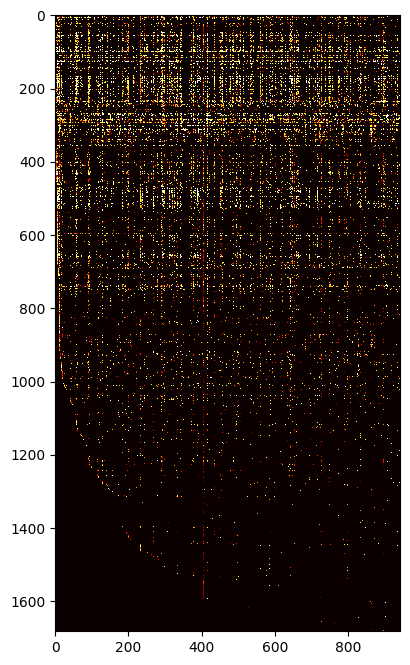

In [14]:
plt.imshow(Y_, cmap='hot', interpolation='nearest')

## 2 - Filtrage collaboratif

Nous allons maintenant implémenter l'algorithme de filtrage collaboratif. Afin de faciliter la tâche, nous allons y aller en plusieurs étapes ;-)

**Exercice 2-1 - "Retirer" des données du jeu d'entraînement pour constituer un jeu de test. Prenez 10% des notes pour le test**

In [15]:
# Compléter cette cellule ~ 1-2 lignes de code

In [16]:
np.random.seed(2023)
# Puisque les données semblent ordonnées selon la popularité, échantillonnons aléatoire pour obtenir le jeu de test

indexes = np.where(R_ == 1)
indexes
print(indexes[0].shape)
test_mask = np.random.choice(indexes[0].shape[0], int(0.1 * indexes[0].shape[0]), replace=False)
test_mask
test_0 = indexes[0][test_mask]
test_1 = indexes[1][test_mask]

# On "retirer" les notes de test de l'entraînement
R = R_.copy()
R[test_0, test_1] = 0
Y = Y_

(100000,)


In [17]:
R_.sum()

100000

In [18]:
R_.sum()

100000

In [19]:
#assert(R_.sum() == R.sum() + R_test.sum())
#R.sum()

**Exercice 2-2 - Initialiser les variables `n_movies`, `n_users`. Initialiez aussi n (nombre de features du vecteur profile) à 10**

In [20]:
# Compléter cette cellule ~ 3 lignes de code

In [21]:
n_movies = Y.shape[0] # Attention, il y a toujours de même nombre de films et d'utilisateurs !
n_users = Y.shape[1]
n = 10

**Exercice 2-3 - Initialiser aléatoirement les matrices $\theta$ et $X$**

In [22]:
# Compléter cette cellule ~ 2-3 lignes de code

In [23]:
np.random.seed(2023)
theta = np.random.rand(n_users, n) # Initialiser aléatoirement les vecteurs des paramètres pour chaque user
print(f'theta: {theta.shape}')

X = np.random.rand(n_movies, n) # Initialiser aléatoirement les vecteurs profile "X"
print(f'X: {X.shape}')

theta: (943, 10)
X: (1682, 10)


**Exercice 2-4 - Calculer la fonction de coût non régularisée telle que vue en cours**

In [24]:
# Compléter cette cellule ~ 3 lignes de code

In [25]:
J = R * (np.dot(X, theta.T) - Y)
J = 0.5 * (J**2)
J = J.sum()
print(f'J = {J}')

J = 127686.15648734823


**Exercice 2-5 - Ajouter les termes de régularisation au coût calculé précédemment. Prenez $\lambda=10$**

In [26]:
# Compléter cette cellule ~ 1-2 lignes de code

In [27]:
L = 10
J_reg = J + (L/2)*(X**2).sum() + (L/2)*(theta**2).sum()
print(f'J_reg = {J_reg}')

J_reg = 171100.4767436747


**Exercice 2-6 - À l'aide des question précédentes, complétez la fonction `cost_reg_func()` permettant de calculer le coût régularisé. Notez que pour faciliter l'étape d'apprentissage plus bas dans le notebook, cette fonction n'accepte les paramètres que sous la forme d'un seul vecteur.**

In [28]:
def cost_reg_func(parameters, *args):
    
    # Obtient les arguments de la fonction
    Y, R, L, n_movies, n_users, n = args
    
    # "Déroule" le vecteur de paramètres
    parameters = parameters.reshape(n_movies + n_users, n)
    
    # "Sépare" X et theta
    X = parameters[:n_movies,:]
    theta = parameters[n_movies:,]
    
    # Compléter le code ci-dessous ~ 1-4 lignes de code
    
    J = R * (np.dot(X, theta.T) - Y)
    J = 0.5 * (J**2)
    J = J.sum()
    J_reg = J + (L/2)*(X**2).sum() + (L/2)*(theta**2).sum()

    return J_reg

La cellule ci-dessous permet de tester la fonction `cost_reg_func`. Vous devriez obtenir une valuer identique à celle de la **question 2-3**

In [29]:
parameters = np.vstack([X, theta]).flatten()
cost_reg_func(parameters, *(Y, R, 10, n_movies, n_users, n))

171100.4767436747

**Exercice 2-7 - Calculez les gradient non régularisés de $X$ et $\theta$**

In [30]:
# Compléter cette cellule ~ 2-4 lignes de code

In [31]:
X_grad = R*(np.dot(X, theta.T) - Y)
X_grad = np.dot(X_grad, theta)
print(f'X_grad: {X_grad.shape}')

theta_grad = R*(np.dot(X, theta.T) - Y)
theta_grad = np.dot((theta_grad).T, X)
print(f'theta_grad: {theta_grad.shape}')

X_grad: (1682, 10)
theta_grad: (943, 10)


**Exercice 2-8 - Ajoutez la régularisation aux gradients calculés précédemment**

In [32]:
# Compléter cette cellule ~ 2-3 lignes de code

In [33]:
X_grad = X_grad + L * X;
theta_grad = theta_grad + L * theta;

**Exercice 2-9 - À l'aide des question précédentes, complétez la fonction `grad_reg_func()` permettant de calculer les gradients régularisés. Comme pour l'exercice 2-4, notez que pour faciliter l'étape d'apprentissage plus bas dans le notebook, cette fonction n'accepte les paramètres que sous la forme d'un seul vecteur.**

In [34]:
def grad_reg_func(parameters, *args):
    # Obtient les arguments de la fonction
    Y, R, L, n_movies, n_users, n = args
    
    # "Déroule" le vecteur de paramètres
    parameters = parameters.reshape(n_movies + n_users, n)
    
    # "Sépare" X et theta
    X = parameters[:n_movies,:]
    theta = parameters[n_movies:,]
    
    # Compléter le code ci-dessous ~ 6 lignes de code
    
    X_grad = R*(np.dot(X, theta.T) - Y)
    X_grad = np.dot(X_grad, theta)
    
    theta_grad = R*(np.dot(X, theta.T) - Y)
    theta_grad = np.dot((theta_grad).T, X)
    
    X_grad_reg = X_grad + L * X;
    theta_grad_reg = theta_grad + L * theta;
    
    # Cette fonction doit retourner les gradients sous forme d'un seul vecteur
    return np.vstack([X_grad_reg, theta_grad_reg]).flatten()

La cellule ci-dessous permet de tester la fonction `grad_reg_func`. 

In [35]:
parameters = np.vstack([X, theta]).flatten()
grad_reg_func(parameters, *(Y, R, 10, n_movies, n_users, n))

array([-264.56180364, -255.86531053, -251.38509448, ..., -103.64163811,
       -104.93826166, -103.93656197])

## 3 - Entraînement du filtrage collaboratif

Maintenant que nous avons les fonctions `cost_reg_func` et `grad_reg_func`, nous pouvons procéder à la phase d'entraînement de note système de recommandation basé sur le filtrage collaboratif. Pour rappel, nous devons trouver la valeur des paramètres qui minimisent la fonction de coût.

**Exercice 3-1: Avant d'entraîner votre modèle, normalisez par la moyenne les notes du jeu de données. N'oubliez pas que certaines données ont été réservées au test**

In [36]:
# Compléter cette cellule ~ 4-5 lignes de code

In [38]:
Y_sum = (R*Y).sum(axis = 1)
R_sum = R.sum(axis = 1)
R_sum[R_sum == 0] = 1 # Astuce pour éviter la divison par zéro pour les films sans aucune note
Y_mean = Y_sum / R_sum

Y_norm = Y - Y_mean.reshape(-1,1)
Y_norm

array([[ 1.10843373,  0.10843373, -3.89156627, ...,  1.10843373,
        -3.89156627, -3.89156627],
       [-0.2       , -3.2       , -3.2       , ..., -3.2       ,
        -3.2       ,  1.8       ],
       [ 0.93023256, -3.06976744, -3.06976744, ..., -3.06976744,
        -3.06976744, -3.06976744],
       ...,
       [-2.        , -2.        , -2.        , ..., -2.        ,
        -2.        , -2.        ],
       [-3.        , -3.        , -3.        , ..., -3.        ,
        -3.        , -3.        ],
       [-3.        , -3.        , -3.        , ..., -3.        ,
        -3.        , -3.        ]])

**Exercice 3-2: Entraînez votre modèle à l'aide de la fonction `fmin_cg` de la librairie SciPy. Référez-vous à la documentation ci-dessous pour les détails de mise en oeuvre. Prenez $\lambda=10$**<br/>
[scipy.optimize.fmin_cg](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html)<br/>
**Remarque: selon votre machine, l'optimisation peut durer plusieurs minutes**

In [39]:
# Compléter la cellule ci-dessous

In [40]:
from scipy import optimize

initial_parameters = np.vstack([X, theta]).flatten()

model = optimize.fmin_cg(cost_reg_func, initial_parameters, fprime=grad_reg_func, args=(Y_norm, R, 10, n_movies, n_users, n))

Optimization terminated successfully.
         Current function value: 35297.807228
         Iterations: 309
         Function evaluations: 461
         Gradient evaluations: 461


## 4 - Effectuer les prédiction

**Exercice 4-1 - À l'aide des éléments vus en cours, effectuez les prédictions (vous devrez d'abord "extraire" les vecteur $X$ et $\theta$ du modèle. Calculez la moyenne des prédictions pour le premier film de la liste. Comparez avec la valeur obtenue à l'exercice 1-4**

In [41]:
# Compléter cette cellule ~ 1-2 lignes de code

In [42]:
model_ = model.reshape(n_movies+n_users, n)
X_trained = model_[:n_movies,:]
theta_trained = model_[n_movies:,:]

predictions = np.dot(X_trained, theta_trained.T)
predictions[0,:].mean() + Y_mean[0]

3.8685533741199203

**Exercice 4-2 - Calculez l'erreur de prédiction sur le jeu de test.Choisissez une métrique appropriée**

In [43]:
# Compléter cette cellule ~ 2-4 lignes de code

In [44]:
res = (predictions[test_0, test_1] - Y_norm[test_0, test_1])
rss = (res**2).sum()
mse = rss / test_0.shape[0]
rmse = np.sqrt(mse)
rmse

0.9484395818128839

## 5 - Recommandation basée sur le contenu (optionnel)

Nous allons maintenant ajouter un nouvel utilisateur (vous-même !) au jeu de données et apprendre le vecteurs de paramètres correspondant. Puisque nous n'ajoutons pas de nouveaux films, nous pouvons garder les vecteurs $X$ et appliquer une recommandation basée sur le contenu

**Exercice 5-1 - En vous réferant à la liste des films, choisissez environ 10 films que vous connaissez et notez les**

In [45]:
# Compléter cette cellule ~ 2-4 lignes de code

In [46]:
# Ajout du nouvel utilisateur
Y_own = np.zeros((n_movies, 1))
R_own = np.zeros((n_movies, 1))
Y_own[np.array([6,10,11,16,7,27,32,68,71,49,81])] = np.array([4,5,4,3,1,4,2,4,5,4,5]).reshape(-1,1)

# Normalisation
Y_own = Y_own - Y_mean.reshape(-1,1)
R_own[[6,10,11,16,7,27,32,68,71,49,81]] = 1

In [47]:
Y_new = np.c_[Y_norm, Y_own]
R_new = np.c_[R, R_own]

**Exercice 5-2 - Adaptez les fonctions `cost_reg_func` et `grad_reg_func` pour correspondre à la recommandation basée sur le contenu**

In [48]:
# Compléter cette cellule

In [49]:
def cost_reg_func(parameters, *args):
    
    # Obtient les arguments de la fonction
    X, Y, R, L, n_movies, n_users, n = args
    
    # "Déroule" le vecteur de paramètres
    theta = parameters.reshape(n_users, n)
    
    # Compléter le code ci-dessous ~ 1-4 lignes de code
    
    J = R * (np.dot(X, theta.T) - Y)
    J = 0.5 * (J**2)
    J = J.sum()
    J_reg = J + (L/2)*(X**2).sum() + (L/2)*(theta**2).sum()

    return J_reg

In [50]:
def content_based_grad_reg_func(parameters, *args):
    # Obtient les arguments de la fonction
    X, Y, R, L, n_movies, n_users, n = args
    
    # "Déroule" le vecteur de paramètres
    theta = parameters.reshape(n_users, n)
    
    # Compléter le code ci-dessous ~ 6 lignes de code
    
    theta_grad = R*(np.dot(X, theta.T) - Y)
    theta_grad = np.dot((theta_grad).T, X)
    
    theta_grad_reg = theta_grad + L * theta;
    
    # Cette fonction doit retourner les gradients sous forme d'un seul vecteur
    return theta_grad_reg.flatten()

**Exercice 5-3 - Entraînez le modèle pour apprendre les paramètres $\theta$ et réalisez les prédictions pour le nouvel utilisateur**

In [51]:
# Compléter cette cellule ~ 6-8 lignes de code

In [52]:
initial_parameters = np.random.rand(n_users+1, n).flatten()
model = optimize.fmin_cg(cost_reg_func, initial_parameters, fprime=content_based_grad_reg_func, args=(X_trained, Y_new, R_new, 10, n_movies, n_users+1, n))

model_ = model.reshape(n_users+1, n)
predictions = np.dot(X_trained, model_.T)
predictions = predictions + Y_mean.reshape(-1,1)

predictions[:,-1]

Optimization terminated successfully.
         Current function value: 35356.146876
         Iterations: 30
         Function evaluations: 63
         Gradient evaluations: 63


array([3.80655628, 3.16511927, 3.11325988, ..., 2.        , 3.        ,
       3.        ])

## 6 - Films similaires

**Exercice 6-1 - Trouvez le film le plus similaire à Star Wars (celui de 1977)**

In [ ]:
# Compléter cette cellule ~ 5-10 lignes de code

In [ ]:
from sklearn.neighbors import NearestNeighbors

sw_index = 49
sw_profile = X_trained[sw_index,:].reshape(1,-1)
neigh = NearestNeighbors(n_neighbors=1, metric="cosine")
neigh.fit(X_trained)
nearest = neigh.kneighbors(sw_profile, 2)
nearest

L'indice 171 correspond à Empire Strikes Back !

## Fin du TP